In [29]:
import phoebe
from spice.models.binary import Binary
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_transform import transform
from spice.models.phoebe_utils import PhoebeConfig
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
import jax.numpy as jnp
from phoebe.parameters.dataset import _mesh_columns
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')

In [30]:
from spice.models.mesh_view import get_mesh_view


def default_icosphere(n, model_mass=1., model_radius=1.):
    return get_mesh_view(IcosphereModel.construct(n, model_radius, model_mass, [5700, 0.], ['teff', 'abun']), jnp.array([0., 1., 0.]))
body_back = default_icosphere(1000)

body_front = transform(default_icosphere(200, 0.75, 0.75), jnp.array([0., 1., 0.]))

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(
/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


In [31]:
from spice.models.mesh_view import Grid


grid = Grid.construct(body_back, body_front, 10)

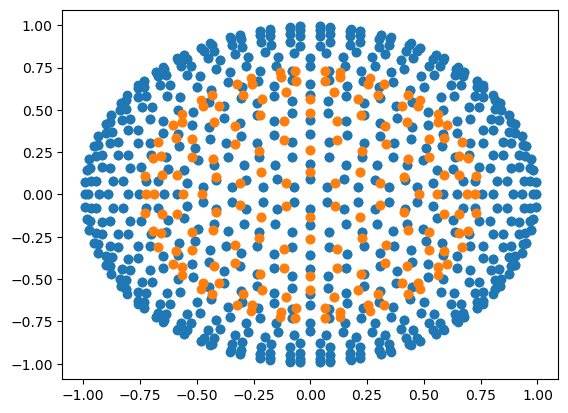

In [32]:
import matplotlib.pyplot as plt

plt.plot(body_back.centers[:, 0], body_back.centers[:, 2], 'o')
plt.plot(body_front.centers[:, 0], body_front.centers[:, 2], 'o')

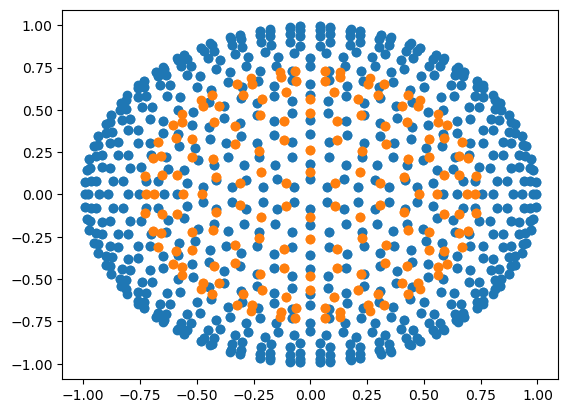

In [33]:
plt.plot(body_back.cast_centers[:, 0], body_back.cast_centers[:, 2], 'o')
plt.plot(body_front.cast_centers[:, 0], body_front.cast_centers[:, 2], 'o')


In [35]:
from scipy.spatial import KDTree

In [ ]:
import jaxkd

In [38]:
tree_back = jaxkd.build_tree(body_back.cast_centers)
tree_front = jaxkd.build_tree(body_front.cast_centers)

In [53]:
tree_back

Tree(points=Array([[-0.5419383 , -0.07076223],
       [-0.6268914 , -0.15157709],
       [-0.49652728, -0.20137173],
       ...,
       [ 0.89220524,  0.        ],
       [ 0.9426334 , -0.08159448],
       [ 0.9299421 ,  0.        ]], dtype=float32), indices=Array([102, 825, 958, ..., 188, 182, 286], dtype=int32), split_dims=Array([ 0,  1,  1, ..., -1, -1, -1], dtype=int8))

In [58]:
tree_back.points.shape, tree_back.indices.shape, tree_back.split_dims.shape

((1280, 2), (1280,), (1280,))

In [60]:
jaxkd.build_tree(jnp.zeros((10, 3)))

Tree(points=Array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32), indices=Array([6, 3, 8, 1, 5, 7, 9, 0, 2, 4], dtype=int32), split_dims=Array([ 0,  0,  0,  0,  0, -1, -1, -1, -1, -1], dtype=int8))

In [ ]:
# Create a mock tree with the same structure as tree_back, but all arrays filled with zeros

def zero_tree_like(tree):
    # Recursively fill all arrays in the tree with zeros of the same shape and dtype
    if isinstance(tree, dict):
        return {k: zero_tree_like(v) for k, v in tree.items()}
    elif isinstance(tree, (list, tuple)):
        return type(tree)(zero_tree_like(v) for v in tree)
    elif hasattr(tree, 'shape') and hasattr(tree, 'dtype'):
        return jnp.zeros_like(tree)
    else:
        return tree  # for non-array leaves

mock_tree_back = zero_tree_like(tree_back)
mock_tree_front = zero_tree_like(tree_front)


(1280, 2)

In [39]:
coords_back = body_back.cast_centers[body_back.mus > 0, :]
coords_front = body_front.cast_centers[body_front.mus > 0, :]

In [ ]:
jnp.argmin(jnp.abs(jnp.cumsum(jnp.sort(body_back.cast_areas[body_back.mus > 0])) - jnp.max(body_front.cast_areas[body_front.mus > 0]))).item()

38

In [ ]:
jnp.cumsum(jnp.sort(body_back.cast_areas))

Array(0.02473837, dtype=float32)

In [45]:
jnp.max(body_front.cast_areas)

Array(0.02402162, dtype=float32)

In [ ]:
n_neighbors = 16
neighbors, distances = jaxkd.query_neighbors(tree2, coords1, k=n_neighbors)
print(neighbors.shape, distances.shape)
coords2[neighbors]

(624, 16) (624, 16)


Array([[[ 0.6688144 , -0.30822152],
        [ 0.69391584, -0.21740372],
        [-0.13068938, -0.69391584],
        ...,
        [ 0.32214916,  0.6526811 ],
        [ 0.        ,  0.13143279],
        [ 0.43194437, -0.5883621 ]],

       [[ 0.7282487 , -0.10893159],
        [ 0.6556855 , -0.22634134],
        [ 0.69391584, -0.21740372],
        ...,
        [ 0.32214916,  0.6526811 ],
        [ 0.6688144 , -0.30822152],
        [ 0.32214916,  0.6526811 ]],

       [[ 0.7282487 , -0.10893159],
        [ 0.6556855 , -0.22634134],
        [ 0.69391584, -0.21740372],
        ...,
        [-0.6688144 ,  0.30822152],
        [ 0.32214916,  0.6526811 ],
        [ 0.32214916,  0.6526811 ]],

       ...,

       [[ 0.32214916,  0.6526811 ],
        [ 0.32214916,  0.6526811 ],
        [ 0.32214916,  0.6526811 ],
        ...,
        [ 0.32214916,  0.6526811 ],
        [ 0.32214916,  0.6526811 ],
        [ 0.32214916,  0.6526811 ]],

       [[ 0.32214916,  0.6526811 ],
        [ 0.32214916,  0.65

/var/folders/7r/n_x0ntj511v_0gt816mgrc1c0000gq/T/ipykernel_49909/4074097551.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


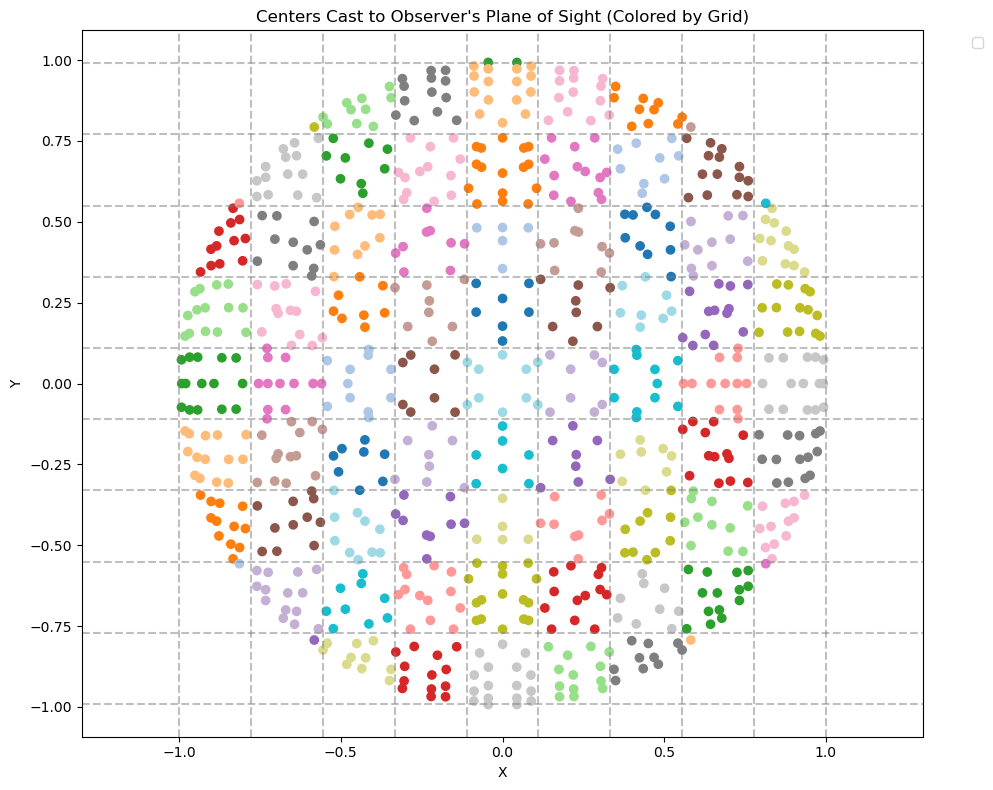

In [ ]:
from functools import partial
import jax
from spice.geometry.utils import append_value_to_last_nan
from spice.models.mesh_model import MeshModel
from spice.models.mesh_view import create_grid_dictionaries, get_grid_index, get_neighbouring, total_visible_area
from spice.models.utils import cast_to_normal_plane
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Create grid dictionaries
(_, grids_m1, reverse_grids_m1), (_, grids_m2, reverse_grids_m2) = create_grid_dictionaries(body_back, body_front, grid)
reverse_grids_m1 = jnp.nan_to_num(reverse_grids_m1, -1)
reverse_grids_m2 = jnp.nan_to_num(reverse_grids_m2, -1)
# Create a colormap
# Create a colormap for the categories in reverse_grids_m1 and reverse_grids_m2
# Convert pairs of numbers to tuples for unique categories
unique_categories = np.unique(np.vstack((reverse_grids_m1, reverse_grids_m2)), axis=0)
n_categories = len(unique_categories)
cmap = plt.get_cmap('tab20')
category_colors = {tuple(cat): cmap(i % 20) for i, cat in enumerate(unique_categories)}

# Plot the cast centers with colors based on grid allocation
plt.figure(figsize=(10, 8))

mus1 = body_back.mus > 0
plt.scatter(body_back.cast_centers[mus1, 0], body_back.cast_centers[mus1, 1],
            c=[category_colors[tuple([int(x[0]), int(x[1])])] for x in reverse_grids_m1[mus1]])

mus2 = body_front.mus > 0
plt.scatter(body_front.cast_centers[mus2, 0], body_front.cast_centers[mus2, 1],
            c=[category_colors[tuple([int(x[0]), int(x[1])])] for x in reverse_grids_m2[mus2]])
    
for x in grid.x:
    plt.axvline(x, color='gray', linestyle='--', alpha=0.5)
for y in grid.y:
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Centers Cast to Observer\'s Plane of Sight (Colored by Grid)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [ ]:
from spice.models.mesh_view import resolve_occlusion


body_back_occluded = resolve_occlusion(body_back, body_front, grid)

In [ ]:
jnp.max(body_back_occluded.occluded_areas)

Array(0.01096571, dtype=float32)

In [ ]:
jnp.max(body_back_occluded.cast_areas)

Array(0.01096569, dtype=float32)

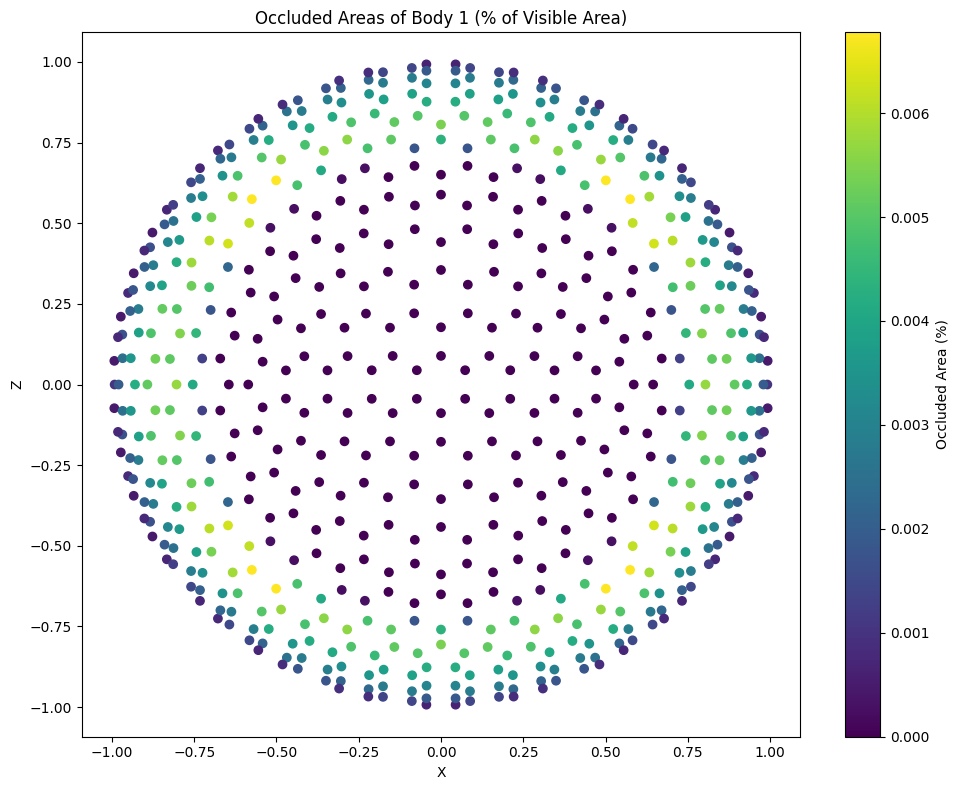

In [ ]:
# Plot occluded areas as a percentage for body_back
plt.figure(figsize=(10, 8))
b_mu = body_back_occluded.mus > 0
plt.scatter(body_back_occluded.centers[b_mu, 0], body_back_occluded.centers[b_mu, 2], c=body_back_occluded.cast_areas[b_mu], cmap='viridis')
plt.colorbar(label='Occluded Area (%)')
plt.title('Occluded Areas of Body 1 (% of Visible Area)')
plt.xlabel('X')
plt.ylabel('Z')
plt.tight_layout()
plt.show()


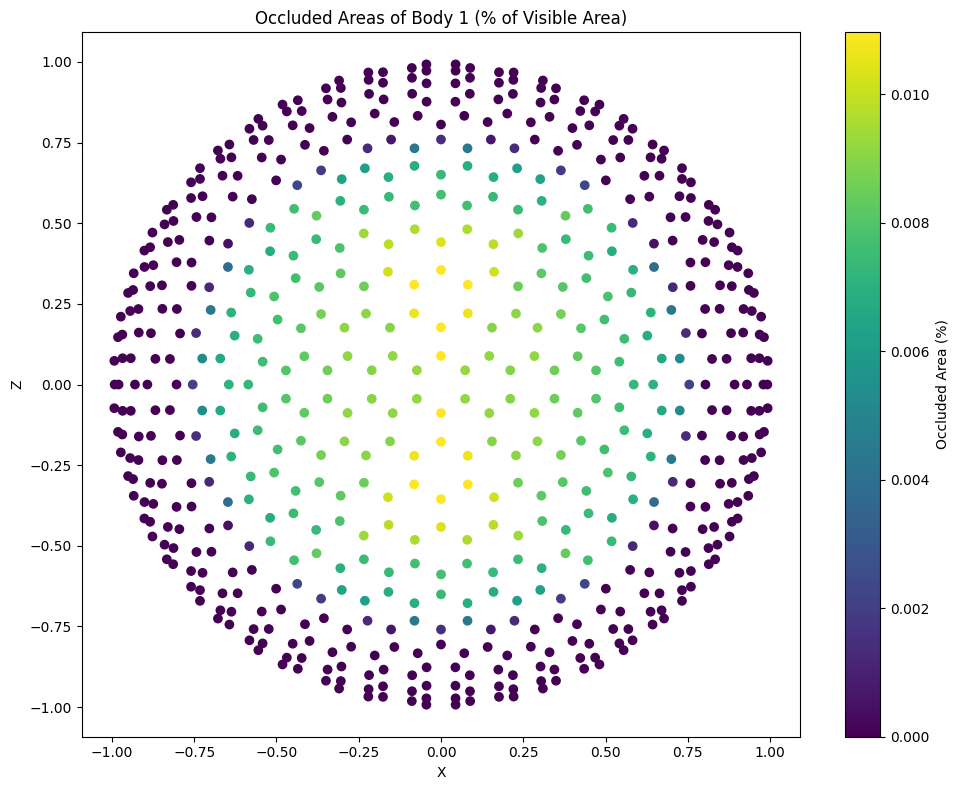

In [ ]:
# Plot occluded areas as a percentage for body_back
plt.figure(figsize=(10, 8))
b_mu = body_back_occluded.mus > 0
plt.scatter(body_back_occluded.centers[b_mu, 0], body_back_occluded.centers[b_mu, 2], c=body_back_occluded.occluded_areas[b_mu], cmap='viridis')
plt.colorbar(label='Occluded Area (%)')
plt.title('Occluded Areas of Body 1 (% of Visible Area)')
plt.xlabel('X')
plt.ylabel('Z')
plt.tight_layout()
plt.show()

Test 1 - Overlapping triangles intersection shape: (12, 2)
Test 1 - Non-nan points: 12

Test 2 - Non-overlapping triangles intersection shape: (12, 2)
Test 2 - Non-nan points: 0

Test 3 - Nested triangles intersection shape: (12, 2)
Test 3 - Non-nan points: 12


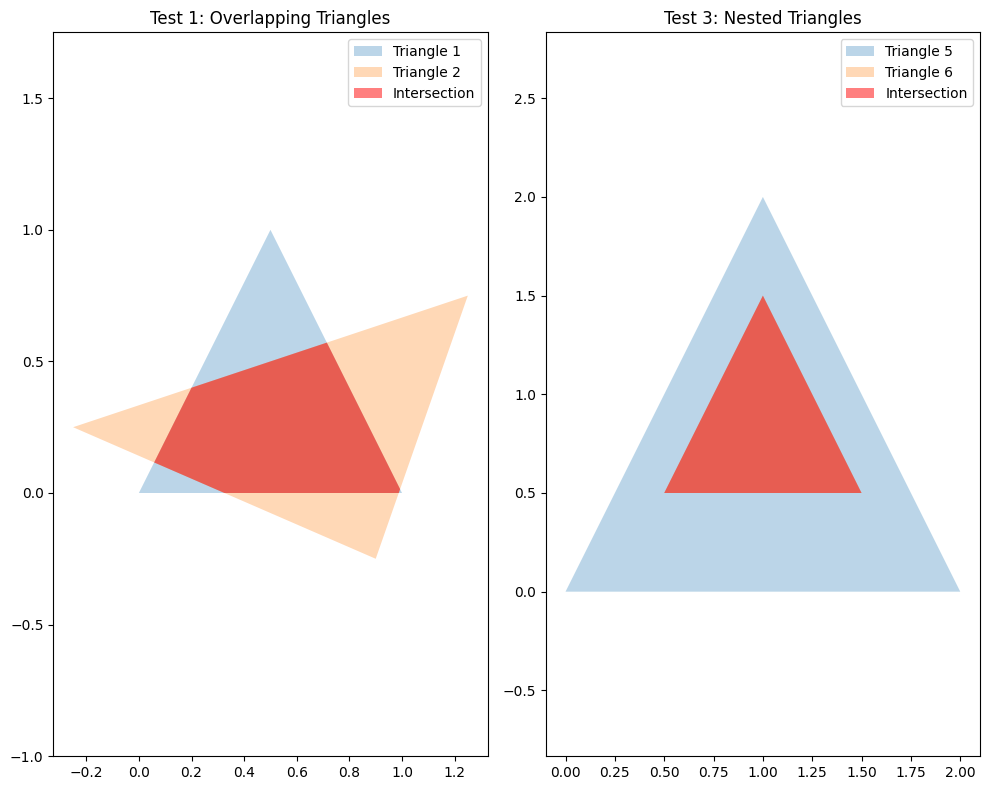

In [12]:
# Test cases for sutherland_hodgman.clip()
from spice.geometry.sutherland_hodgman import clip
import jax.numpy as jnp

# Test 1: Two overlapping triangles
triangle1 = jnp.array([[0., 0.], [1., 0.], [0.5, 1.]])
triangle2 = jnp.array([[-0.25, 0.25], [0.9, -0.25], [1.25, 0.75]])
intersection1 = clip(triangle1, triangle2)
print("Test 1 - Overlapping triangles intersection shape:", intersection1.shape)
print("Test 1 - Non-nan points:", jnp.sum(~jnp.isnan(intersection1[:, 0])))

# Test 2: Non-overlapping triangles 
triangle3 = jnp.array([[0., 0.], [1., 0.], [0.5, 1.]])
triangle4 = jnp.array([[2., 2.], [3., 2.], [2.5, 3.]])
intersection2 = clip(triangle3, triangle4)
print("\nTest 2 - Non-overlapping triangles intersection shape:", intersection2.shape)
print("Test 2 - Non-nan points:", jnp.sum(~jnp.isnan(intersection2[:, 0])))

# Test 3: One triangle completely inside another
triangle5 = jnp.array([[0., 0.], [2., 0.], [1., 2.]])
triangle6 = jnp.array([[0.5, 0.5], [1.5, 0.5], [1., 1.5]])
intersection3 = clip(triangle5, triangle6)
print("\nTest 3 - Nested triangles intersection shape:", intersection3.shape)
print("Test 3 - Non-nan points:", jnp.sum(~jnp.isnan(intersection3[:, 0])))

# Visualize test case 1
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.fill(triangle1[:, 0], triangle1[:, 1], alpha=0.3, label='Triangle 1')
plt.fill(triangle2[:, 0], triangle2[:, 1], alpha=0.3, label='Triangle 2')
valid_points = ~jnp.isnan(intersection1[:, 0])
plt.fill(intersection1[valid_points, 0], intersection1[valid_points, 1], 'r', alpha=0.5, label='Intersection')
plt.legend()
plt.title('Test 1: Overlapping Triangles')
plt.axis('equal')

# Visualize test case 3
plt.subplot(122)
plt.fill(triangle5[:, 0], triangle5[:, 1], alpha=0.3, label='Triangle 5')
plt.fill(triangle6[:, 0], triangle6[:, 1], alpha=0.3, label='Triangle 6')
valid_points = ~jnp.isnan(intersection3[:, 0])
plt.fill(intersection3[valid_points, 0], intersection3[valid_points, 1], 'r', alpha=0.5, label='Intersection')
plt.legend()
plt.title('Test 3: Nested Triangles')
plt.axis('equal')
plt.tight_layout()
plt.show()



Testing polygon_area function:
Area of simple triangle: 0.5
Area of square: 1.0
Area of rectangle: 2.0


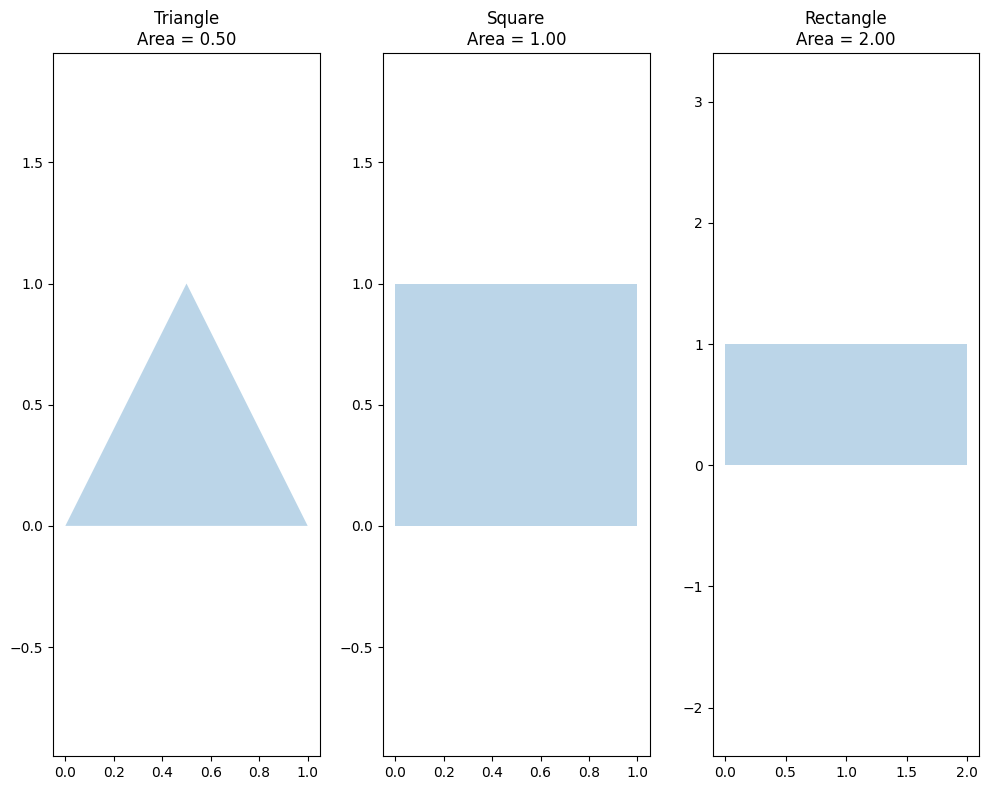

In [13]:
# Test polygon_area function from utils.py
from spice.geometry.utils import polygon_area


print("\nTesting polygon_area function:")

# Test case 1: Simple triangle
triangle = jnp.array([[0., 0.], [1., 0.], [0.5, 1.]])
area0 = polygon_area(triangle[:, 0], triangle[:, 1])
print(f"Area of simple triangle: {area0}")
# Expected area = 0.5 * base * height = 0.5 * 1 * 1 = 0.5

# Test case 2: Square
square = jnp.array([[0., 0.], [1., 0.], [1., 1.], [0., 1.]])
area1 = polygon_area(square[:, 0], square[:, 1])
print(f"Area of square: {area1}")
# Expected area = 1.0

# Test case 3: Rectangle
rectangle = jnp.array([[0., 0.], [2., 0.], [2., 1.], [0., 1.]])
area2 = polygon_area(rectangle[:, 0], rectangle[:, 1])
print(f"Area of rectangle: {area2}")
# Expected area = 2.0

# Visualize the test polygons
plt.figure(figsize=(10, 8))
plt.subplot(131)
plt.fill(triangle[:, 0], triangle[:, 1], alpha=0.3)
plt.title(f'Triangle\nArea = {area0:.2f}')
plt.axis('equal')

plt.subplot(132)
plt.fill(square[:, 0], square[:, 1], alpha=0.3)
plt.title(f'Square\nArea = {area1:.2f}')
plt.axis('equal')

plt.subplot(133)
plt.fill(rectangle[:, 0], rectangle[:, 1], alpha=0.3)
plt.title(f'Rectangle\nArea = {area2:.2f}')
plt.axis('equal')

plt.tight_layout()
plt.show()
